***


# Projet :  Isomorphisme de graphes
***
***


Thibault Godin <br>
_IUT de Vannes département Informatique_


In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#magic
import warnings
warnings.filterwarnings('ignore')

import time


import pandas as pd

# Présentation du problème

Le problème de l'isomorphisme de graphe consiste à savoir si deux graphes sont, essentiellement, identiques.

Plus précisément :

>**Isomorphisme de graphes : définition**<br>
>Deux graphes $\mathcal{G}=(S,A)$ et $\mathcal{H}=(T,B)$ sont isomorphes s'il existe une bijection $f : S \to T$ >telle que $\{a,a'\} \in A \Longleftrightarrow \{f(a),f(a')\} \in B$	



Par exemple : 

<img src="isom1.png" width="500">



sont isomorphes. Un isomorphisme possible est :


$f(0)=a,f(1)=d, f(2)=f, f(3)=e,f(4) =c, f(5) = b$

Ce problème est important à la fois du point de vue théorique et du point de vue pratique.

_D'un point de vue théorique_ c'est un des rares problèmes qui n'est pas dans $\mathbf{P}$ (on ne connait pas d'algorithme résolvant l'isomorphisme en temps polynomial) mais qui n'est pas non plus $\mathbf{NP}$-complet (le problème est clairement dans $\mathbf{NP}$ car si on donne l'isomorphisme correct la vérification se fait en temps linéaire).

C'est donc un problème qui se situe entre ces deux classes de complexité. On rappelle que la question $\mathbf{P}  \overset{?}{=}  \mathbf{NP}$ est centrale en informatique théorique (toute la cryptographie arithmétique type RSA est basée sur la difficulté de $\mathbf{NP}$) et fait partie des prix du millénaire de l'institut Clay.

Actuellement l'algorithme ayant la meilleure complexité théorique est de complexité quasi-polynomiale, en $\exp(O(\ln n)^3) $, du à Babai en 2015 (pour l'annonce, avec quelques corrections et collaboration ultérieures pour la preuve finale).


On pourra noter qu'une légère variation du problème (par exemple chercher une copie d'un graphe $G$ comme sous graphe du graphe $H$, le problème de l'isomorphisme de sous-graphe) devient $\mathbf{NP}$-complet, le problème semble donc être réellement à la frontière entre $\mathbf{P} $ et $\mathbf{NP}$.



_D'un point de vue pratique_ les graphes sont un outil très puissant de modélisation, et on peut par exemple imaginer des applications du type "reconnaitre une molécule dans une base de données", qui s'appliquerait en pharmacologie.

# Graph non-isomorphism for dummies


Le but de ce notebook va être de trouver des critères permettant de prouver que 2 graphes ne sont **pas** isomorphes, puis de comparer ces critères selon deux métriques :

 - la puissance : quelle proportion de graphes est séparée par notre critère ?
 - l'efficacité : quel est le temps d'exécution/la complexité théorique de notre critère ?
 
 notre base de donnée de graphe sera l'**atlas des graphes**, une base exhaustive des graphes (simples, non-orientés) d'ordre inférieur ou égal à $7$, tous uniques _à isomorphisme près_, fournie dans la bibliothèque <tt>networkx</tt>
 
 
Nous testerons les critères :

  - ordre (nombre de sommets)
  - taille (nombre d'arêtes)
  - suite des degrés
  - suite des excentricités
  - spectre d'adjacence
  - spectre laplacien
  
  
ainsi que la conjonction de certains de ces critères.

On travaillera sur les _matrices d'adjacences_ des graphes.

## Benchmark : prise en main

On présente rapidement la base sur laquelle nous allons effectuer nos tests :

In [2]:
G_all = nx.graph_atlas_g()

NUM_GRAPH = len(G_all)
NUM_GRAPH

1253

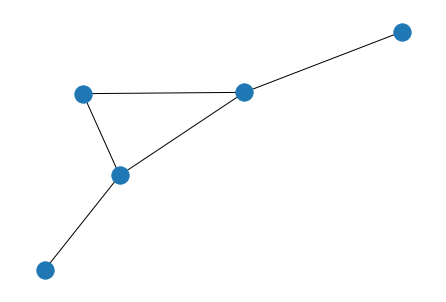

In [3]:
#graph taureau
nx.draw(G_all[35])

In [4]:
G_adj = [nx.to_numpy_array(graph,dtype=int) for graph in G_all]
##standardisation
G_adj[0] = np.array([[0]])
G_adj[35]



array([[0, 1, 1, 0, 1],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]])

La base de graphe étant de taille $1253$, on effectuera $\frac{1253 \times 1252}{2} = 784\:378$ appels à chaque test d'un critère.



In [5]:
cnt=0
for i in range(NUM_GRAPH):
    for j in range(i+1,NUM_GRAPH):
        cnt = cnt +1
        
cnt, NUM_GRAPH*(NUM_GRAPH-1)/2

(784378, 784378.0)

On va stocker nos résultats dans un dataframe panda dont voici la structure :

In [6]:
doNothing = pd.Series({'Critere': 'Aucun',
                        'Efficacite': 0.0,
                        'Non_separes' : NUM_GRAPH*(NUM_GRAPH-1),
                        'Puissance': 0.0})

Critere_Iso = pd.DataFrame([doNothing])

Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0


## Ordre du graphe


Le critère le plus évident est le nombre de sommets, l'**ordre** du graphe.

Deux graphes ayant un nombre différent de sommets ne peuvent pas être isomorphes. 


On va utiliser une fonction précodée en <tt>numpy</tt> mais il est raisonnable de penser que la complexité est linéaire, donc $Ordre(n) = O(n)$.

In [7]:
def ordre(graph):
    return graph.shape[0]

ordre(G_adj[35])

5

In [8]:
def test_ordre():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_adj[i]) == ordre(G_adj[j]):
                unconclusive_cnt = unconclusive_cnt + 1
                unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [9]:
start = time.time()
ordre_cnt,ordre_list = test_ordre()
end = time.time()


duree_ordre = end - start
efficacité_ordre = ordre_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_ordre)
print("non spéparés : ",ordre_cnt, " puissance : ", 1-efficacité_ordre, "%")


durée :  0.767693281173706
non spéparés :  557160  puissance :  0.6451228273996056 %


In [10]:
ordrepd = pd.Series({'Critere': 'Ordre',
                        'Efficacite': duree_ordre,
                        'Non_separes' : ordre_cnt,
                        'Puissance': 1-efficacité_ordre})

Critere_Iso = pd.concat([Critere_Iso, ordrepd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123


Ce critère est donc très efficace (la complexité est très bonne), mais très peu puissante. C'était attendu car c'est le critère le plus naïf possible.


-----------------

## Taille du graphe


Le critère suivant est le nombre d'arêtes, la **taille** du graphe.

Deux graphes ayant un nombre différent d'arêtes ne peuvent pas être isomorphes. 


L'algorithme naïf pour calculer la taille se base sur une variation du _lemme des poignées de main_, on somme tous les éléments de la matrice puis on divise par $2$. La complexité est donc quadratique, $Taille(n) = O(n^2)$.

In [11]:
def taille(graph):
    return sum(sum(graph))//2


taille(G_adj[35])

5

In [12]:
def test_taille():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if taille(G_adj[i]) == taille(G_adj[j]):
                unconclusive_cnt = unconclusive_cnt + 1
                unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [13]:
start = time.time()
taille_cnt,taille_list = test_taille()
end = time.time()


duree_taille = end - start
efficacité_taille = taille_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_taille)
print("non spéparés : ",taille_cnt, " efficacité : ", 1-efficacité_taille, "%")

durée :  10.748990058898926
non spéparés :  70156  efficacité :  0.9553148773764211 %


In [14]:
taillepd = pd.Series({'Critere': 'Taille',
                        'Efficacite': duree_taille,
                        'Non_separes' : taille_cnt,
                        'Puissance': 1-efficacité_taille})

Critere_Iso = pd.concat([Critere_Iso, taillepd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315


Le critère est déjà nettement plus puissant, mais devient déjà plus lent. On peut essayer de combiner les deux, le critère de l'ordre étant quasiment gratuit au regard de celui de la taille

In [15]:

def test_ordretaille():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_adj[i]) == ordre(G_adj[j]) :
                if taille(G_adj[i]) == taille(G_adj[j]):
                    unconclusive_cnt = unconclusive_cnt + 1
                    unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive



In [16]:
start = time.time()
ordretaille_cnt,ordretaille_list = test_ordretaille()
end = time.time()


duree_ordretaille = end - start
efficacité_ordretaille = ordretaille_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_ordretaille)
print("non spéparés : ",taille_cnt, " efficacité : ", 1-efficacité_ordretaille, "%")

durée :  8.511829137802124
non spéparés :  70156  efficacité :  0.9644772510713321 %


In [17]:
ordretaillepd = pd.Series({'Critere': 'OrdreTaille',
                        'Efficacite': duree_ordretaille,
                        'Non_separes' : ordretaille_cnt,
                        'Puissance': 1-efficacité_ordretaille})

Critere_Iso = pd.concat([Critere_Iso, ordretaillepd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477


On constate une légère amélioration pour un temps légèrement meilleur (on coupe certains calculs en ne considérant pas les graphes trivialement différents). Cette stratégie est donc à privilégier.


------------

## Degré

Le calcul de la taille est finalement un peu artificiel, puisqu'on calcule les degrés (le nombre de voisins de chaque sommet) en sommant ligne par ligne, avant de sommer le tout.

On va donc calculer la liste (triée) des degrés. La complexité est alors de $O(n \times n)$ (on fait $n$ sommes de lignes de longueur $n$) puis $O(n\ln n)$ (tri de la liste des degrés. Globalement on est donc en $O(n^2)$.

In [18]:
def degres(graph):
    return np.sort(sum(graph))

degres(G_adj[35])



array([1, 1, 2, 3, 3])

__Remarque :__
- Pour Linux, ajouter le critère ordre n'est pas pertinent car le test numpy vérifie déjà cela, comme montré ci-dessous (à l'exception des graphes de taille 0 et 1 qui sont des cas particuliers (il sera sans doute pertinent de les enlever).
- Pour Windows, on a besoin de tester l'ordre d'abord ! (les cases suivantes ne fonctionnent pas -> Passez directement à "test_ordredegres")

In [19]:
print(np.all(degres(G_adj[4]) == degres(G_adj[2])))
print(np.alltrue(degres(G_adj[4]) == degres(G_adj[1])))

False
True


In [20]:
def test_degres():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if np.alltrue(degres(G_adj[i]) == degres(G_adj[j])):
                unconclusive_cnt = unconclusive_cnt + 1
                unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [21]:
start = time.time()
degres_cnt,degres_list = test_degres()
end = time.time()


duree_degres = end - start
efficacité_degres = degres_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_degres)
print("non spéparés : ", degres_cnt, " efficacité : ", 1-efficacité_degres, "%")

durée :  20.909059524536133
non spéparés :  3388  efficacité :  0.9978420492124881 %


In [22]:
degrespd = pd.Series({'Critere': 'Degres',
                        'Efficacite': duree_degres,
                        'Non_separes' : degres_cnt,
                        'Puissance': 1-efficacité_degres})

Critere_Iso = pd.concat([Critere_Iso, degrespd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842


L'efficacité est divisée par deux par rapport à la taille, mais la puissance est multipliée par 10, c'est donc une amélioration.

__Les utilisateurs de Windows reviennent ici !__

In [23]:
def test_ordredegres():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_adj[i]) == ordre(G_adj[j]) : 
                if np.alltrue(degres(G_adj[i]) == degres(G_adj[j])):
                    unconclusive_cnt = unconclusive_cnt + 1
                    unconclusive.append([i,j])

                
    return unconclusive_cnt,unconclusive

In [24]:
start = time.time()
ordredegres_cnt,ordredegres_list = test_ordredegres()
end = time.time()


duree_ordredegres = end - start
efficacité_ordredegres = ordredegres_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_ordredegres)
print("non spéparés : ", ordredegres_cnt, " efficacité : ", 1-efficacité_ordredegres, "%")

durée :  13.532360792160034
non spéparés :  3376  efficacité :  0.9978496924856434 %


In [25]:
ordredegrespd = pd.Series({'Critere': 'OrdreDegres',
                        'Efficacite': duree_ordredegres,
                        'Non_separes' : ordredegres_cnt,
                        'Puissance': 1-efficacité_ordredegres})

Critere_Iso = pd.concat([Critere_Iso, ordredegrespd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785


Le gain en puissance est mineur mais celui en efficacité est sensible.

-----------------

## Excentricités


Une autre caractéristique d'un degré est sa distance aux autres degrés, son _excentricité_.

L'algorithme qui calcule cette valeur est plus compliqué, on passe ici l'algorithme de Floyd-Warshall afin d'obtenir la matrice des distances, puis on prend le maximum ligne à ligne.

Floyd-Warshall est en $O(n^3)$ tandis que le maximum est en $O(n)$ et le tri en $O(n \ln n)$. Le critère est donc en $O(n^3)$.

In [26]:
def FloydWarshall(A):
    
    W = np.copy(A)    
    n = A.shape[0]
    W = W.astype(float)
    #prétraitement, matrice pondérée des distances initiales
    for i in range(n):
        for j in range(n):
            if W[i,j]==0 :
                W[i,j] = np.inf
                
    for i in range(n):
        W[i,i]=0
    #coeur de l'algorithme
    for i in range(n):
        for j in range(n):
            for k in range(n):
                W[i,j] = min(W[i,j],W[i,k]+W[k,j])
    return W
print(FloydWarshall(G_adj[35]))

[[0. 1. 1. 2. 1.]
 [1. 0. 1. 2. 2.]
 [1. 1. 0. 1. 2.]
 [2. 2. 1. 0. 3.]
 [1. 2. 2. 3. 0.]]


In [27]:
def excentricites(graph):
    dist = FloydWarshall(graph)
    exc = np.max(dist,axis=0)
    
    return np.sort(exc)

excentricites(G_adj[35])

array([2., 2., 2., 3., 3.])

In [28]:
def test_excentricites():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_adj[i]) == ordre(G_adj[j]) : #obligatoire pour le bon fonctionnement de la comparaison suivante
                if np.allclose(excentricites(G_adj[i]),excentricites(G_adj[j])): ##floating point -> changing == to close
                    unconclusive_cnt = unconclusive_cnt + 1
                    unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [29]:
start = time.time()
excentricites_cnt,excentricites_list = test_excentricites()
end = time.time()


duree_excentricites = end - start
efficacité_excentricites = excentricites_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_excentricites)
print("non spéparés : ", excentricites_cnt, " efficacité : ", 1-efficacité_excentricites, "%")

durée :  351.7594358921051
non spéparés :  68472  efficacité :  0.9563874833758809 %


In [30]:
excentricitespd = pd.Series({'Critere': 'Excentricites',
                        'Efficacite': duree_excentricites,
                        'Non_separes' : excentricites_cnt,
                        'Puissance': 1-efficacité_excentricites})

Critere_Iso = pd.concat([Critere_Iso, excentricitespd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785
0,Excentricites,351.759436,68472,0.956387


Le critère commence à prendre un certain temps, pour une puissance moyenne. On peut cependant essayer de l'employer en complément de notre critère "degrés".

In [31]:
def test_degresexcentricites():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_adj[i]) == ordre(G_adj[j]) : #obligatoire pour le bon fonctionnement de la comparaison suivante
                if np.alltrue(degres(G_adj[i]) == degres(G_adj[j])):
                    if np.allclose(excentricites(G_adj[i]),excentricites(G_adj[j])): ##floating point -> changing == to close
                        unconclusive_cnt = unconclusive_cnt + 1
                        unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [32]:
start = time.time()
degresexcentricites_cnt,excentricites_list = test_degresexcentricites()
end = time.time()


duree_degresexcentricites = end - start
efficacité_degresexcentricites = degresexcentricites_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_degresexcentricites)
print("non spéparés : ", degresexcentricites_cnt, " efficacité : ", 1-efficacité_degresexcentricites, "%")

durée :  15.763463735580444
non spéparés :  1243  efficacité :  0.9992082842889972 %


In [33]:
degresexcentricitespd = pd.Series({'Critere': 'DegresExcentricites',
                        'Efficacite': duree_degresexcentricites,
                        'Non_separes' : degresexcentricites_cnt,
                        'Puissance': 1-efficacité_degresexcentricites})

Critere_Iso = pd.concat([Critere_Iso, degresexcentricitespd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785
0,Excentricites,351.759436,68472,0.956387
0,DegresExcentricites,15.763464,1243,0.999208


-----------

# Approche algébrique : Valeurs propres

Un puissant invariant de matrice est leur spectre, c'est-à-dire l'ensemble des valeurs propres.

Pour rappel : 

Soit $M$ une matrice. $ \alpha$ est une \textbf{valeur propre} de $M$ si $\exists \mathbf{v}, \: \: M\mathbf{v} = \alpha \mathbf{v}$
Si $M$ est une matrice, on notera $sp(M)$ son spectre, c'est-à-dire la liste (triée) de toutes ses valeurs propres (deux-à-deux indépendantes).


La partie des maths qui s'intéresse aux valeurs propres des graphes est la **théorie algébrique des graphes**. C'est un domaine dynamique qui trouve ses origines et ses applications notamment dans la chimie et les sciences des données (ACP, clustering spectral ...).





## Matrice d'adjacence

Il est standard que si $M$ et $M'$ sont deux matrices d'adjacences de graphes isomorphe, alors $sp(M) = sp(N)$.


On va utiliser la réciproque comme critère.
Le calcul du spectre (approché) est en $O(n^3)$ (mais comme le problème est important et bien étudié, les implémentations sont généralement plus efficaces en pratique).

On va utiliser <tt>np.linalg.eigvals</tt> qui traite spécifiquement les matrices symétriques (c'est le cas de nos matrices d'adjacences) pour lesquels des résultats forts existent.




In [34]:
def spectreAdj(graph):
    sp = np.linalg.eigvals(graph)
    
    return np.sort(sp)

spectreAdj(G_adj[35]) ## on voit ici qu'on obtient seulement une approximation, le spectre théorique est [1/2 * (-1 - sqrt(5)) ;  1/2 + (1 - sqrt(13)) ;  0 ;  1/2 * (-1 + sqrt(5)) ; 1/2 + (1 + sqrt(13))]

array([-1.61803399e+00, -1.30277564e+00,  5.35809654e-17,  6.18033989e-01,
        2.30277564e+00])

In [35]:
def test_spectreAdj():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_adj[i]) == ordre(G_adj[j]) : #obligatoire pour le bon fonctionnement de la comparaison suivante
                if np.allclose(spectreAdj(G_adj[i]),spectreAdj(G_adj[j])): ##floating point -> changing == to close
                    unconclusive_cnt = unconclusive_cnt + 1
                    unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [36]:
start = time.time()
spectreAdj_cnt,spectreAdj_list = test_spectreAdj()
end = time.time()


duree_spectreAdj = end - start
efficacité_spectreAdj = spectreAdj_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_spectreAdj)
print("non spéparés : ", spectreAdj_cnt, " efficacité : ", 1-efficacité_spectreAdj, "%")

durée :  67.47574234008789
non spéparés :  65  efficacité :  0.9999585989370755 %


In [37]:
spectreAdjpd = pd.Series({'Critere': 'SpectreAdjacence',
                        'Efficacite': duree_spectreAdj,
                        'Non_separes' : spectreAdj_cnt,
                        'Puissance': 1-efficacité_spectreAdj})

Critere_Iso = pd.concat([Critere_Iso, spectreAdjpd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785
0,Excentricites,351.759436,68472,0.956387
0,DegresExcentricites,15.763464,1243,0.999208
0,SpectreAdjacence,67.475742,65,0.999959


L'utilisation d'une bibliothèque externe rend l'efficacité tout à fait acceptable, surtout à la vue du la puissance. On peut toutefois remarquer l'existence de paires non-séparées alors que des critères précédant feraient la différence. Par exemple :

In [38]:
spectreAdj_list[1] #paire cospectrale (non triviale)

[28, 29]

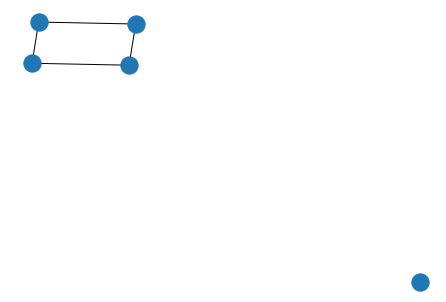

In [39]:
nx.draw(G_all[28])

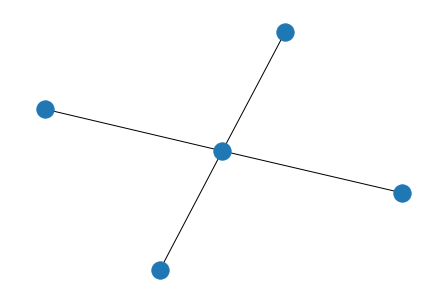

In [40]:
nx.draw(G_all[29])

On peut rajouter le critère "degré", qui est très efficace et relativement puissant

In [41]:
def test_degreeSpectreAdj():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_adj[i]) == ordre(G_adj[j]) : #obligatoire pour le bon fonctionnement de la comparaison suivante
                if np.alltrue(degres(G_adj[i]) == degres(G_adj[j])):
                    if np.allclose(spectreAdj(G_adj[i]),spectreAdj(G_adj[j])): ##floating point -> changing == to close
                        unconclusive_cnt = unconclusive_cnt + 1
                        unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [42]:
start = time.time()
degreeSpectreAdj_cnt,degreeSpectreAdj_list = test_degreeSpectreAdj()
end = time.time()


duree_degreeSpectreAdj = end - start
efficacité_degreeSpectreAdj = degreeSpectreAdj_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_degreeSpectreAdj)
print("non spéparés : ",degreeSpectreAdj_cnt, " efficacité : ", 1-efficacité_degreeSpectreAdj, "%")

durée :  13.879982709884644
non spéparés :  1  efficacité :  0.9999993630605704 %


In [43]:
degreespectreAdjpd = pd.Series({'Critere': 'DegreeSpectreAdjacence',
                        'Efficacite': duree_degreeSpectreAdj,
                        'Non_separes' : degreeSpectreAdj_cnt,
                        'Puissance': 1-efficacité_degreeSpectreAdj})

Critere_Iso = pd.concat([Critere_Iso, degreespectreAdjpd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785
0,Excentricites,351.759436,68472,0.956387
0,DegresExcentricites,15.763464,1243,0.999208
0,SpectreAdjacence,67.475742,65,0.999959
0,DegreeSpectreAdjacence,13.879983,1,0.999999



## Matrice Laplacienne

Une autre matrice très importante en théorie spectrale des graphes est la **matrice Laplacienne**.


Cette matrice est définie comme $L_G =  M_G - \Delta_G$ où $M_G$ est la matrice d'adjacence du graphe et $\Delta_G$ est la matrice diagonale contenant les degrés des sommets.

Là encore la complexité est, au pire, en $O(n^3)$



In [44]:
#la matrice laplacienne étant une matrice classique, elle est implémentée dans networkx au même titre que la matrice d'adjacence
G_lapl= G_adj.copy()
#la matrice d'adjacence du graphe à 1 sommet n'est pas défini, il faut donc le traiter à part#
G_lapl[0] = np.array([[0]])
G_lapl[1:] = [nx.laplacian_matrix(graph).toarray() for graph in G_all[1:]]


G_lapl[35]


array([[ 3, -1, -1,  0, -1],
       [-1,  2, -1,  0,  0],
       [-1, -1,  3, -1,  0],
       [ 0,  0, -1,  1,  0],
       [-1,  0,  0,  0,  1]])

In [45]:
def spectreLapl(graph):
    sp = np.linalg.eigvals(graph)    
    return np.sort(sp)

spectreAdj(G_lapl[35]) ## on voit ici qu'on obtient seulement une approximation, le spectre théorique est contient 0

array([9.26785575e-17, 6.97224362e-01, 1.38196601e+00, 3.61803399e+00,
       4.30277564e+00])

In [46]:
def test_spectreLapl():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_lapl[i]) == ordre(G_lapl[j]) : #ordre fonctionne aussi avec lapl
                if np.allclose(spectreLapl(G_lapl[i]),spectreLapl(G_lapl[j])): ##floating point -> changing == to close
                    unconclusive_cnt = unconclusive_cnt + 1
                    unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [47]:
start = time.time()
spectreLapl_cnt,spectreLapl_list = test_spectreLapl()
end = time.time()


duree_spectreLapl = end - start
efficacité_spectreLapl = spectreLapl_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_spectreLapl)
print("non spéparés : ", spectreLapl_cnt, " efficacité : ", 1-efficacité_spectreLapl, "%")

durée :  65.14037990570068
non spéparés :  77  efficacité :  0.9999509556639202 %


In [48]:
spectreLaplpd = pd.Series({'Critere': 'SpectreLaplacien',
                        'Efficacite': duree_spectreLapl,
                        'Non_separes' : spectreLapl_cnt,
                        'Puissance': 1-efficacité_spectreLapl})

Critere_Iso = pd.concat([Critere_Iso, spectreLaplpd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785
0,Excentricites,351.759436,68472,0.956387
0,DegresExcentricites,15.763464,1243,0.999208
0,SpectreAdjacence,67.475742,65,0.999959
0,DegreeSpectreAdjacence,13.879983,1,0.999999


Là aussi, on peut utiliser les degrés, en utilisant la structre de la laplacienne pour plus d'efficacité

In [49]:
def test_degreeSpectreLapl():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère

    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_lapl[i]) == ordre(G_lapl[j]) : #ordre fonctionne aussi avec lapl
                if np.alltrue(np.sort(np.diag((G_lapl[i]))) == np.sort(np.diag((G_lapl[j])))):                
                    if np.allclose(spectreLapl(G_lapl[i]),spectreLapl(G_lapl[j])): ##floating point -> changing == to close
                        unconclusive_cnt = unconclusive_cnt + 1
                        unconclusive.append([i,j])
                
                
    return unconclusive_cnt,unconclusive

In [50]:
start = time.time()
degreeSpectreLapl_cnt,degreeSpectreLapl_list = test_degreeSpectreLapl()
end = time.time()


duree_degreeSpectreLapl = end - start
efficacité_degreeSpectreLapl = degreeSpectreLapl_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_degreeSpectreLapl)
print("non spéparés : ", degreeSpectreLapl_cnt, " efficacité : ", 1-efficacité_degreeSpectreLapl, "%")

durée :  8.829781532287598
non spéparés :  39  efficacité :  0.9999751593622452 %


In [51]:
degreeSpectreLaplpd = pd.Series({'Critere': 'DegreeSpectreLaplacien',
                        'Efficacite': duree_degreeSpectreLapl,
                        'Non_separes' : degreeSpectreLapl_cnt,
                        'Puissance': 1-efficacité_degreeSpectreLapl})

Critere_Iso = pd.concat([Critere_Iso, degreeSpectreLaplpd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785
0,Excentricites,351.759436,68472,0.956387
0,DegresExcentricites,15.763464,1243,0.999208
0,SpectreAdjacence,67.475742,65,0.999959
0,DegreeSpectreAdjacence,13.879983,1,0.999999


Enfin, on se demande s'il existe des (petits) graphes cospectraux pour la matrice d'adjacence _et_ la matrice laplacienne.

In [52]:
def test_SpectresAdjLapl():
    
    unconclusive_cnt = 0 ## nombre de paires non séparées par le critère
    unconclusive = [] ## paires non séparées par le critère
    cnt1 = 0
    cnt2 = 0
    
    for i in range(NUM_GRAPH):
        for j in range(i+1,NUM_GRAPH):
            if ordre(G_lapl[i]) == ordre(G_lapl[j]) : #ordre fonctionne aussi avec lapl
                cnt2 = cnt2+1
 
                if np.allclose(spectreAdj(G_adj[i]),spectreAdj(G_adj[j])): ##floating point -> changing == to close
                    cnt1 = cnt1+1
                    if np.allclose(spectreLapl(G_lapl[i]),spectreLapl(G_lapl[j])): ##floating point -> changing == to close
                        unconclusive_cnt = unconclusive_cnt + 1
                        unconclusive.append([i,j])
                
    print(cnt1,cnt2)           
    return unconclusive_cnt,unconclusive

In [53]:
start = time.time()
SpectresAdjLapl_cnt,SpectresAdjLapl_list = test_SpectresAdjLapl()
end = time.time()


duree_SpectresAdjLapl = end - start
efficacité_SpectresAdjLapl = SpectresAdjLapl_cnt/(NUM_GRAPH * NUM_GRAPH-1)

print("durée : ", duree_SpectresAdjLapl)
print("non spéparés : ", SpectresAdjLapl_cnt, " efficacité : ", 1-efficacité_SpectresAdjLapl, "%")

65 557160
durée :  63.05851340293884
non spéparés :  1  efficacité :  0.9999993630605704 %


In [54]:
SpectresAdjLaplpd = pd.Series({'Critere': 'SpectresAdjacenceLaplacien',
                        'Efficacite': duree_SpectresAdjLapl,
                        'Non_separes' : SpectresAdjLapl_cnt,
                        'Puissance': 1-efficacité_SpectresAdjLapl})

Critere_Iso = pd.concat([Critere_Iso, SpectresAdjLaplpd.to_frame().T])
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785
0,Excentricites,351.759436,68472,0.956387
0,DegresExcentricites,15.763464,1243,0.999208
0,SpectreAdjacence,67.475742,65,0.999959
0,DegreeSpectreAdjacence,13.879983,1,0.999999


--------------

# Conclusion

Voici le résumé de nos expérimentations : 

In [55]:
Critere_Iso

,Critere,Efficacite,Non_separes,Puissance
0,Aucun,0.0,1568756,0.0
0,Ordre,0.767693,557160,0.645123
0,Taille,10.74899,70156,0.955315
0,OrdreTaille,8.511829,55771,0.964477
0,Degres,20.90906,3388,0.997842
0,OrdreDegres,13.532361,3376,0.99785
0,Excentricites,351.759436,68472,0.956387
0,DegresExcentricites,15.763464,1243,0.999208
0,SpectreAdjacence,67.475742,65,0.999959
0,DegreeSpectreAdjacence,13.879983,1,0.999999


On constate que, même si le problème est théoriquement complexe, on arrive à le résoudre en pratique sur de petits exemples avec des critères relativement simples. 

En particulier les deux critères naïfs **Ordre** et **Degrés** sont particulièrement efficaces et puissants. Ils doivent certainement être effectués en premiers et systématiquement.

La méthode de **Excentricité** est couteuse et ne présente pas un avantage conséquent par rapport aux méthodes naïves, elle semble donc utile seulement si on a déjà calculé la matrice des distances (ce qui peut être le cas dans certaines applications.


Les méthodes algébriques, **Spectre d'adjacence** et **Spectre Laplacien** sont quant à elles certes couteuse mais très puissantes. Le coût est légèrement amorti par l'utilisation de bibliothèques externes (car l'étude des valeurs propres d'une matrice est un problème fondamental en mathématiques appliquées, physique, traitement du signal et de l'image). Leur utilisation associée au calcul de degré est particulièrement puissant (tous les graphes sont séparés par **Degree-Spectre d'adjacence**, hormis le cas particulier du couple <tt>(atlas[0],atlas[1])</tt>).

De plus l'association des deux spectres sépare elle aussi toutes les paires. Une étude un peu plus approfondie de ces approches est faite [dans cet article](https://arxiv.org/pdf/2212.05297)

On remarque néanmoins que nos nombres de paires cospectrales diffère pour le spectre Laplacien. Il conviendrait de récupérer leur implémentation afin de mieux comprendre si cette différence est du à des approximations différentes du spectre, une erreur théorique ou une autre raison à déterminer.


Il serait bien entendu intéressant d'approfondir notre étude (notamment en poussant l'ordre des graphes au delà de $7$, même si cela fera forcément exploser le temps de calcul).

Comme nous n'avons utilisé que des algorithmes polynomiaux nos critères ne sont absolument pas parfaits pour des graphes plus gros. En revanche il est probable que ces critères fonctionnent bien pour des graphes _aléatoires_ (pour une définition raisonnable d'aléatoire), les cas problématiques rendant le problème difficile étant finalement assez rares en pratique.

Trouver d'autres critères simples (taille du $2$-voisinage par exemple) semble également un axe intéressant.


Enfin, on peut se demander si l'efficacité d'un critère dépend de l'ordre du graphe, ou si au contraire certains critères deviennent plus pertinents quand l'ordre augmente.
Pour cela il serait intéressant de calculer la puissance de chaque critère à une taille donnée puis de les comparer ou de les classer, pour voir si ce classement évolue significativement. Pour ce problème encore plus particulièrement il faudrait aller au-delà des graphes à $7$ sommets.

-----------------------
-----------------------



### Référence

- Isomorphismes de graphes en temps quasi-polynomial (d'après Babai et Luks, Weisfeiler-Leman...);  _Harald Andrés Helfgott_, [https://arxiv.org/abs/1701.04372](https://arxiv.org/abs/1701.04372)
- Practical graph isomorphism, II ; _Brendan D. McKay, Adolfo Piperno_ [https://arxiv.org/abs/1301.1493](https://arxiv.org/abs/1301.1493
- Which graphs are determined by their spectrum? ; _Edwin R. van Dam, Willem H. Haemers ; [https://www.sciencedirect.com/science/article/pii/S002437950300483X](https://www.sciencedirect.com/science/article/pii/S002437950300483X)
- The Degree-Distance and Transmission-Adjacency Matrices ; _Carlos A. Alfaro, Octavio Zapata_, [https://arxiv.org/abs/2212.05297](https://arxiv.org/abs/2212.05297)